[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sunyeul/playground/blob/main/Jax/JAX_ODE.ipynb)

In [2]:
from jax import random, grad, vmap, jit, nn
import jax.numpy as np

import matplotlib.pyplot as plt

from typing import List

## Problem 1

$$F'(x) = -2xF(x) $$
$$ init: F(0) = 1$$

In [3]:
def F(x:float) -> float:
    return np.exp(-x**2)

F_vec = vmap(F, (0))

In [4]:
@jit
def f(params:List[float], x:float) -> float:
    w0 = params[:10]
    b0 = params[10:20]
    x = nn.sigmoid(x * w0 + b0)

    w2 = params[20:30]
    b2 = params[30]
    x = nn.sigmoid(np.dot(x, w2) + b2)

    return x

dfdx = grad(f, 1)

f_vec = vmap(f, (None, 0))
dfdx_vec = vmap(dfdx, (None, 0))

$$\text{minimize: }( f'(x) + 2xf(x) ) ^2 +  (f(0) - 1) ^ 2 $$

In [5]:
@jit
def loss(params, inputs):
    eq = dfdx_vec(params, inputs) + 2. * inputs * f_vec(params, inputs)
    ic = f(params, 0.) - 1
    return np.mean(eq**2) + ic**2
    # return np.mean((F_vec(inputs) - f_vec(params, inputs)) ** 2)

grad_loss = jit(grad(loss, 0))

In [6]:
epochs = 10_000
learning_rate = .1
momentum = .99
velocity = .0

key = random.PRNGKey(0)
params = random.normal(key, shape=(31, ))

inputs = np.linspace(-2., 2., num=401)

for epoch in range(epochs+1):
    if epoch % 1_000 == 0:
        print(f'epoch: {epoch:3d} loss: {loss(params, inputs):.6f}')

    gradient = grad_loss(params + momentum * velocity, inputs)
    velocity = momentum * velocity - learning_rate * gradient
    params += velocity

epoch:   0 loss: 0.954726
epoch: 1000 loss: 0.000191
epoch: 2000 loss: 0.000145
epoch: 3000 loss: 0.000133
epoch: 4000 loss: 0.000123
epoch: 5000 loss: 0.000116
epoch: 6000 loss: 0.000110
epoch: 7000 loss: 0.000104
epoch: 8000 loss: 0.000100
epoch: 9000 loss: 0.000096
epoch: 10000 loss: 0.000093


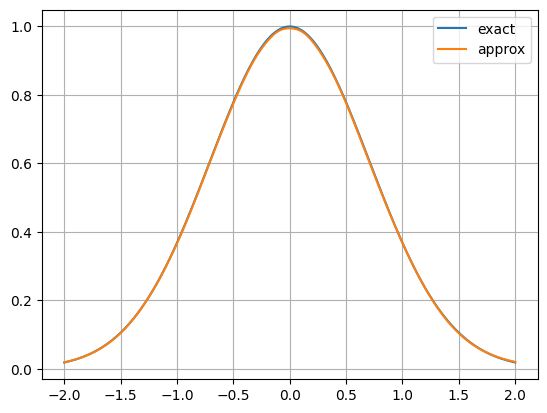

In [7]:
plt.plot(inputs, F(inputs), label="exact")
plt.plot(inputs, f_vec(params, inputs), label="approx")
plt.legend()
plt.grid(True)
plt.show()

## Problem 2

$$F'(x) = 2x + 1 $$
$$ init: F(0) = 1$$

In [8]:
def F(x:float) -> float:
    return x**2 + x + 1

F_vec = vmap(F, (0))

In [20]:
@jit
def f(params:List[float], x:float) -> float:
    w0 = params[:10]
    b0 = params[10:20]
    x = nn.relu(x * w0) + b0

    w1 = params[20:120].reshape(10, 10)
    b1 = params[120:130]
    x = nn.gelu(np.dot(x, w1)) + b1

    w2 = params[130:140]
    b2 = params[140]
    x = nn.relu(np.dot(x, w2)) + b2

    return x

dfdx = grad(f, 1)

f_vec = vmap(f, (None, 0))
dfdx_vec = vmap(dfdx, (None, 0))

In [21]:
@jit
def loss(params, inputs):
    eq = dfdx_vec(params, inputs) - 2. * inputs - 1
    ic = f(params, .0) - 1
    return np.mean((F_vec(inputs) - f_vec(params, inputs)) ** 2)

grad_loss = jit(grad(loss, 0))

In [22]:
epochs = 1_000
learning_rate = .001
momentum = .5
velocity = .0

key = random.PRNGKey(0)
params = random.normal(key, shape=(141, ))

inputs = np.linspace(-2., 2., num=401)
inputs = (inputs - np.max(inputs)) / np.std(inputs)

for epoch in range(epochs+1):
    if epoch % 100 == 0:
        print(f'epoch: {epoch:3d} loss: {loss(params, inputs):.6f}')

    gradient = grad_loss(params + momentum * velocity, inputs)
    velocity = momentum * velocity - learning_rate * gradient
    params += velocity

epoch:   0 loss: 15.922813
epoch: 100 loss: 0.155866
epoch: 200 loss: 0.100224
epoch: 300 loss: 0.070635
epoch: 400 loss: 0.053470
epoch: 500 loss: 0.042386
epoch: 600 loss: 0.034617
epoch: 700 loss: 0.028861
epoch: 800 loss: 0.024417
epoch: 900 loss: 0.020901
epoch: 1000 loss: 0.018078


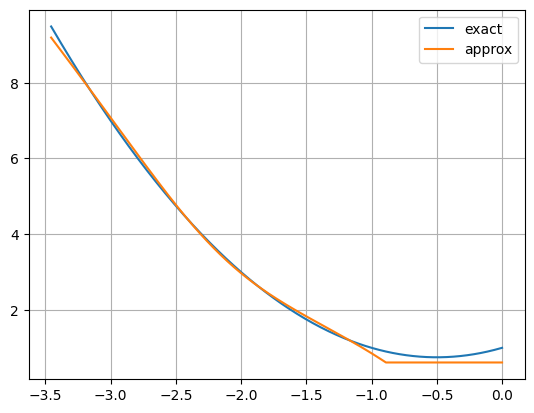

In [23]:
plt.plot(inputs, F(inputs), label="exact")
plt.plot(inputs, f_vec(params, inputs), label="approx")
plt.legend()
plt.grid(True)
plt.show()